# Reducing GPU Memory Footprint for Large Language Models Using Quantisation

Large Language Models (LLMs) have gained significant attention in recent years due to their impressive linguistic and reasoning skills. However, these models tend to have billions of parameters, making them computationally expensive and requiring a cluster of GPUs for efficient inference. The time taken for the LLMs to ingest the prompt and generate token output is known as inference time. Additionally, LLMs are usually large in size, making it difficult to store them in memory. Therefore, reducing the GPU memory footprint of these models is crucial for improving their efficiency and scalability.

Brief Introcution on Language Models(LM): <br>
They are probablistic models trained to generate next word conditioned on the previous sequnce of words generated. They had been considered as an auzillary task to enhance performance of other AI Models, however recent experiments have proved that Large LMs(LLM) exhibit ["learning on the fly" capabilities](https://arxiv.org/abs/2005.14165) and ["aligning LLMs have enabled them to be excellent chatbot agents"](https://arxiv.org/abs/2203.02155).    

**Timeline of Large Language Models**:
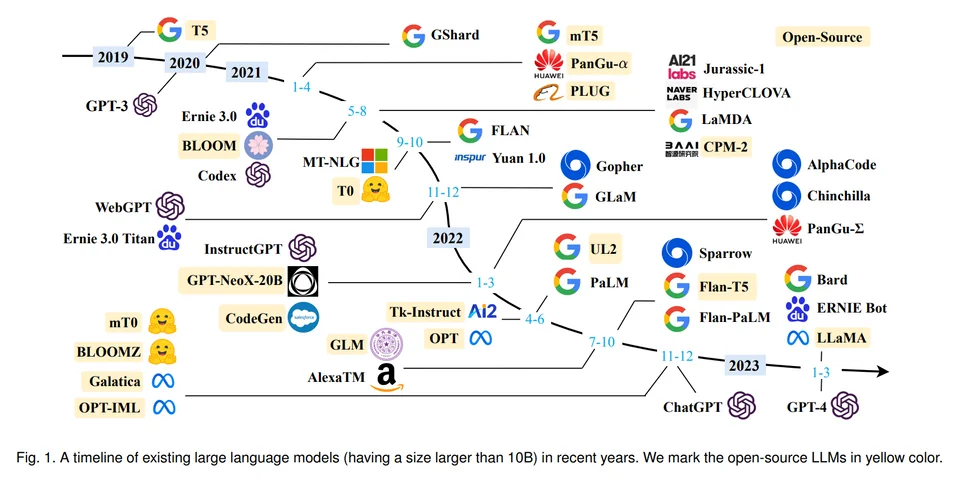

**Well, what are LLMs made of?** <br>
In simple terms, they're just tensors of floating values. If you consider next word generation as a parameterized function, it's parameters are nothing but floating point values in the magnitude of millions/billions.

**Model Size(Number of Parameters) over time:**
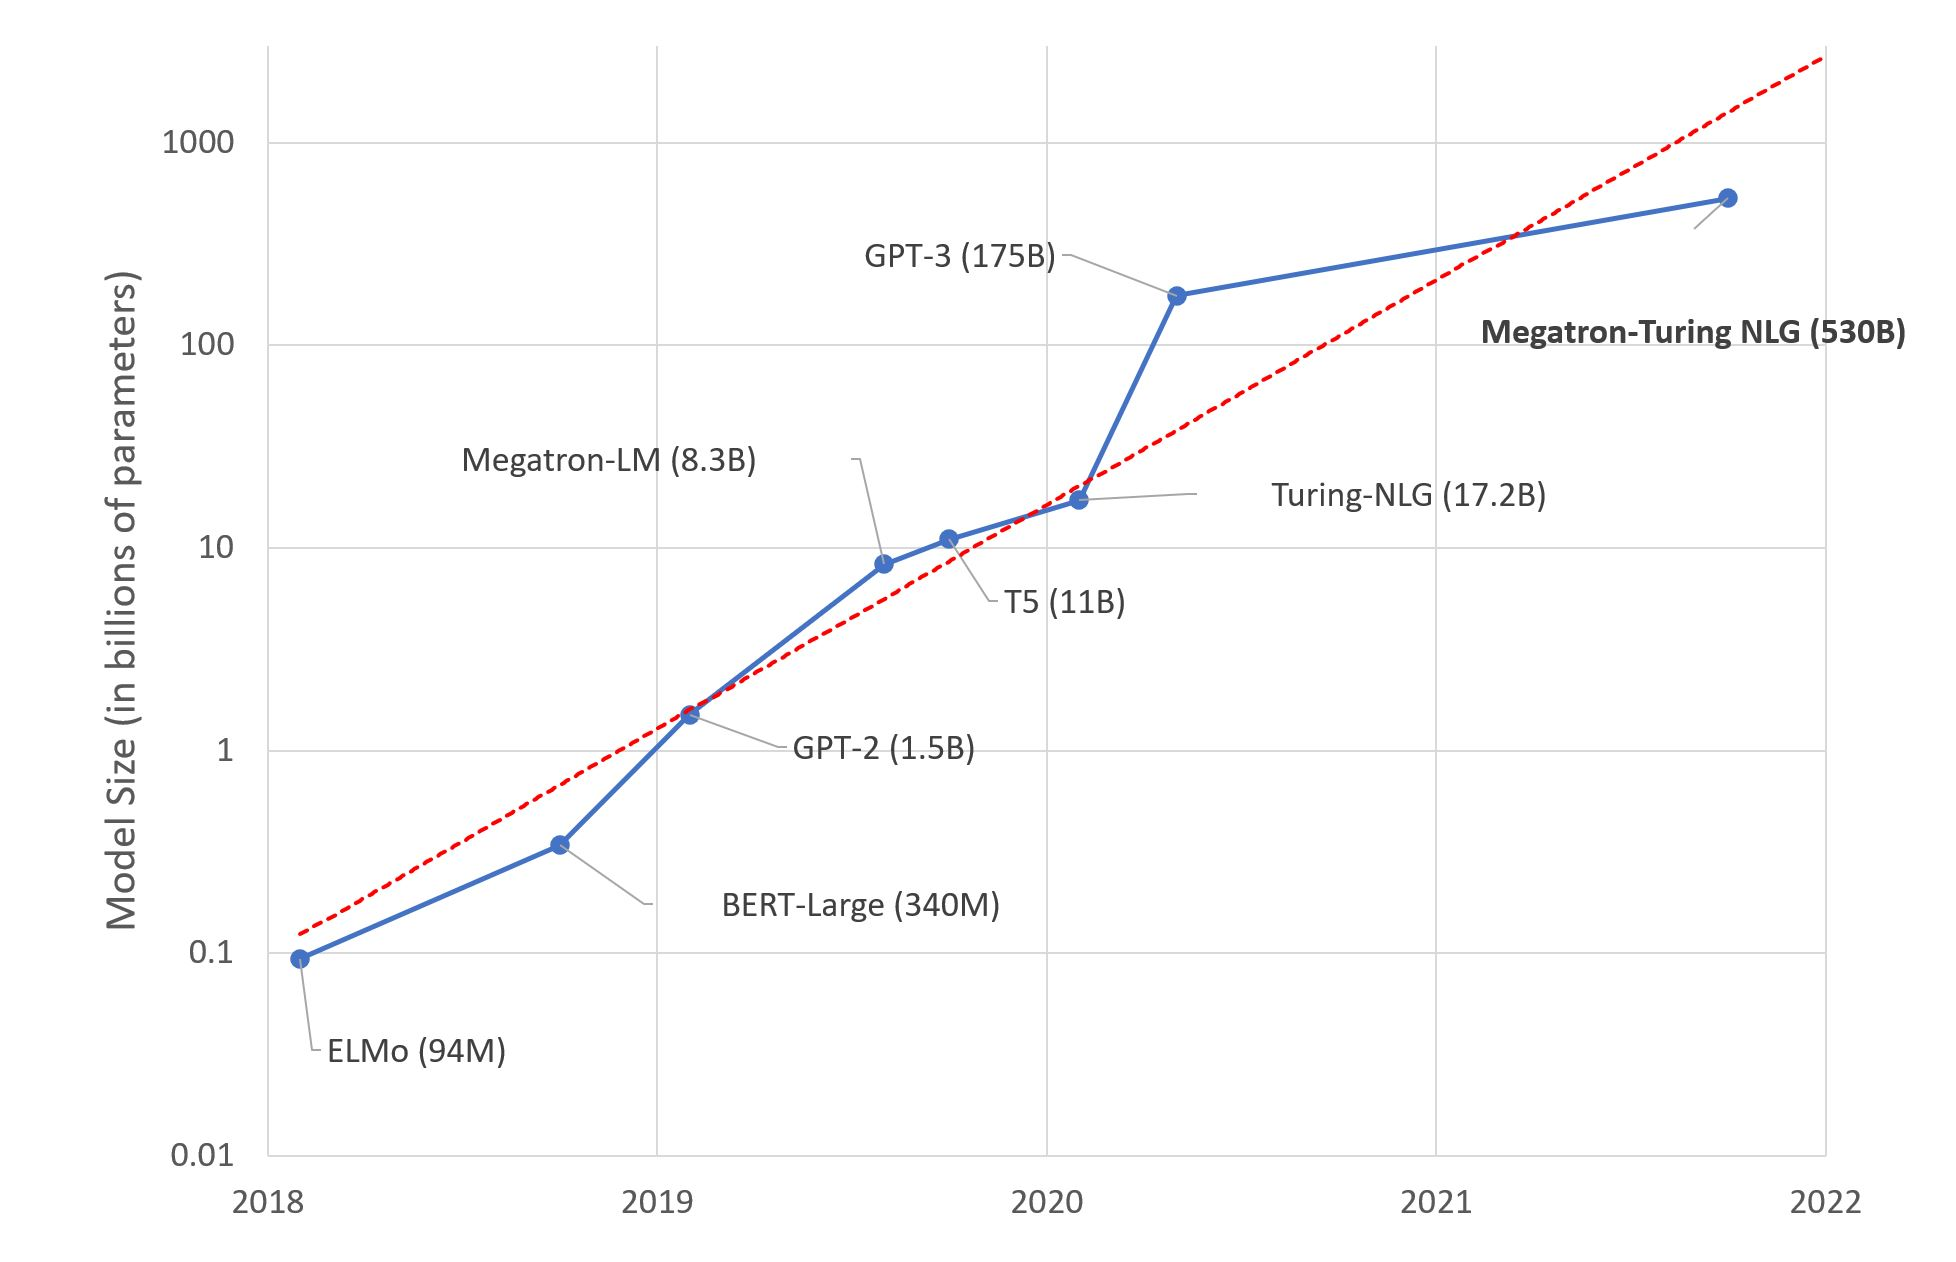

Due to the scale of LLMs, training them is considered a hard and expensive problem to solve. For instance, GPT-3(175B parameters) was trained on a supercomputer developed by OpenAI that had over 285,000 CPU cores, 10,000 GPUs and 400 gigabits per second of network connectivity for each GPU server. Also, in order to infer from LLMs(illicitng outputs from models), we'd first have to load in these Large Language Models onto memory. <br>

Therefore it's important that we explore optimisations on how we can minimize memory fingerprint. 

In [1]:
!pip install transformers
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00


We will be using the t5-3b Model to demonstrate the benifit of memory quantization. 
<br>
Link to model: https://huggingface.co/t5-3b


In [2]:
model_name = "t5-3b-sharded"

In [3]:
# import pytorch and transformers 
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch

In [4]:
model_id=f"ybelkada/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model_8bit = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto", load_in_8bit=True)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
# We need sharded weights otherwise we get CPU OOM errors
model_id=f"ybelkada/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
# helps override float16 default
T5ForConditionalGeneration._keep_in_fp32_modules = None

# model_8bit = T5ForConditionalGeneration.from_pretrained(model_id, device_map="auto", load_in_8bit=True)
model_16bit = T5ForConditionalGeneration.from_pretrained(model_id, device_map="auto", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
model_8bit.get_memory_footprint()

2884624384

In [6]:
model_16bit.get_memory_footprint()

5703196672

The LLM is tested on translation task. Feel free to change the prompt and test it's translation capabilities. 

In [7]:
max_new_tokens = 50

input_ids = tokenizer(
    "translate English to German: Hello my name is Younes and I am a Machine Learning Engineer at Hugging Face", return_tensors="pt"
).input_ids  

outputs = model_8bit.generate(input_ids, max_new_tokens=max_new_tokens)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1405: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Hallo mein Name ist Younes und ich bin ein Ingenieur für Machine Learning bei Hugging Face
